In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/Transfer Learning Tutorial/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
print(dataset_sizes)

{'train': 244, 'val': 153}


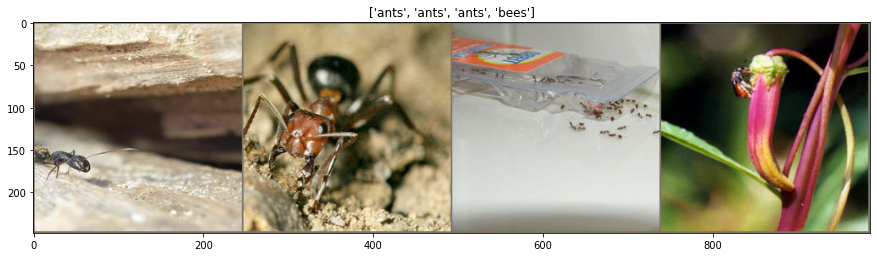

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [5]:
for i in dataloaders['train']:
    print(i[0][0])
    break 

tensor([[[ 0.4851,  0.6392,  0.8276,  ...,  0.5878,  0.6392,  0.6563],
         [ 0.3823,  0.5707,  0.8104,  ...,  0.6049,  0.6392,  0.6734],
         [ 0.2967,  0.5193,  0.7591,  ...,  0.5707,  0.6049,  0.6563],
         ...,
         [-0.9020, -0.9020, -0.8335,  ..., -1.0562, -0.9534, -0.8507],
         [-0.9534, -0.9192, -0.9363,  ..., -0.9705, -0.9534, -0.9020],
         [-0.9705, -0.9192, -0.8678,  ..., -0.9877, -1.0219, -0.9705]],

        [[ 0.5203,  0.7304,  0.8529,  ...,  0.6779,  0.7129,  0.7129],
         [ 0.4503,  0.6429,  0.8004,  ...,  0.6779,  0.7129,  0.7304],
         [ 0.3627,  0.5728,  0.7479,  ...,  0.6604,  0.6954,  0.7479],
         ...,
         [-0.7402, -0.7577, -0.6527,  ..., -0.9853, -0.8803, -0.7577],
         [-0.8277, -0.8102, -0.6702,  ..., -0.9153, -0.7927, -0.7052],
         [-0.8978, -0.8452, -0.7052,  ..., -0.9153, -0.8277, -0.7577]],

        [[ 1.0539,  1.1237,  1.1934,  ...,  1.1062,  1.1237,  1.1585],
         [ 0.9668,  1.0714,  1.1585,  ...,  1

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloaders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                optimizer.zero_grad()

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, losses

In [7]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        else:
            inputs, labels = inputs, labels



        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))

            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

# def visualize_model(model, num_images=6):
#     images_so_far = 0
#     fig = plt.figure()

#     for i, data in enumerate(dataloaders['val']):
#         inputs, labels = data
#         if use_gpu:
#             inputs, labels = inputs.cuda(), labels.cuda()
#         else:
#             inputs, labels = inputs, labels

#         outputs = model(inputs)
#         _, preds = torch.max(outputs.data, 1)

#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(num_images // 2, 2, images_so_far)
#             ax.axis('off')
#             ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#             imshow(inputs.cpu().data[j])

#             if images_so_far == num_images:
#                 return

In [8]:
def evaluate(model):
    model.train(False)

    running_correct = 0
    for data in dataloaders['val']:
        inputs, labels = data

        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        else:
            inputs, labels = inputs, labels

        output = model(inputs)
        _, predicted = torch.max(output, 1)
        print(torch.sum(predicted == labels))
        
        running_correct += int(torch.sum(predicted == labels))
        
    return running_correct / dataset_sizes['val']

In [9]:
model_single_fc = models.alexnet(pretrained=True)

In [10]:
model_single_fc

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
num_features = 9216

model_single_fc.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_single_fc = model_single_fc.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_single_fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_single_fc

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=2, bias=True)
)

In [13]:
model_single_fc, losses = train_model(model_single_fc, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2236 Acc: 0.5984
val Loss: 0.1770 Acc: 0.5817

Epoch 1/24
----------
train Loss: 0.1723 Acc: 0.5779
val Loss: 0.1734 Acc: 0.6340

Epoch 2/24
----------
train Loss: 0.1712 Acc: 0.6107
val Loss: 0.1746 Acc: 0.6275

Epoch 3/24
----------
train Loss: 0.1733 Acc: 0.5697
val Loss: 0.1938 Acc: 0.4706

Epoch 4/24
----------
train Loss: 0.1695 Acc: 0.6230
val Loss: 0.1798 Acc: 0.5556

Epoch 5/24
----------
train Loss: 0.1682 Acc: 0.5902
val Loss: 0.1757 Acc: 0.4902

Epoch 6/24
----------
train Loss: 0.1670 Acc: 0.6066
val Loss: 0.1673 Acc: 0.6405

Epoch 7/24
----------
train Loss: 0.1617 Acc: 0.6516
val Loss: 0.1661 Acc: 0.6667

Epoch 8/24
----------
train Loss: 0.1563 Acc: 0.7049
val Loss: 0.1657 Acc: 0.6405

Epoch 9/24
----------
train Loss: 0.1554 Acc: 0.6598
val Loss: 0.1666 Acc: 0.6405

Epoch 10/24
----------
train Loss: 0.1506 Acc: 0.6680
val Loss: 0.1672 Acc: 0.6471

Epoch 11/24
----------
train Loss: 0.1523 Acc: 0.7008
val Loss: 0.1661 Acc: 0.6797

Ep

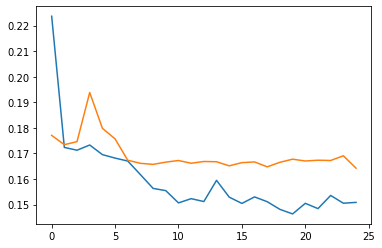

In [14]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [15]:
torch.save(model_single_fc.state_dict(), 'AlexNet_model_single_fc.pth')

In [16]:
model_single_fc.load_state_dict(torch.load('AlexNet_model_single_fc.pth'))


<All keys matched successfully>

In [17]:
print("Accuracy: {0:.4f}".format(evaluate(model_single_fc)))


tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
t

In [18]:
model_last_fc = models.alexnet(pretrained=True)

In [19]:
num_features = 4096

model_last_fc.classifier[6] = nn.Linear(num_features, 2)

if use_gpu:
    model_last_fc = model_last_fc.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_last_fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [20]:
model_last_fc

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
model_last_fc, losses = train_model(model_last_fc, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1963 Acc: 0.6557
val Loss: 0.2382 Acc: 0.4314

Epoch 1/24
----------
train Loss: 0.1584 Acc: 0.6967
val Loss: 0.1160 Acc: 0.8170

Epoch 2/24
----------
train Loss: 0.1314 Acc: 0.7541
val Loss: 0.1158 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.1269 Acc: 0.7418
val Loss: 0.1412 Acc: 0.7712

Epoch 4/24
----------
train Loss: 0.1035 Acc: 0.8197
val Loss: 0.1730 Acc: 0.7516

Epoch 5/24
----------
train Loss: 0.1433 Acc: 0.7459
val Loss: 0.1035 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.0981 Acc: 0.8279
val Loss: 0.1864 Acc: 0.7582

Epoch 7/24
----------
train Loss: 0.0811 Acc: 0.8525
val Loss: 0.1264 Acc: 0.8562

Epoch 8/24
----------
train Loss: 0.0618 Acc: 0.8811
val Loss: 0.0972 Acc: 0.8562

Epoch 9/24
----------
train Loss: 0.0526 Acc: 0.9057
val Loss: 0.0977 Acc: 0.8627

Epoch 10/24
----------
train Loss: 0.0480 Acc: 0.9139
val Loss: 0.0910 Acc: 0.8627

Epoch 11/24
----------
train Loss: 0.0428 Acc: 0.9139
val Loss: 0.0919 Acc: 0.8627

Ep

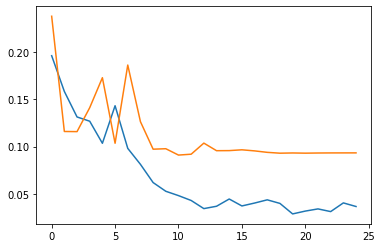

In [22]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [23]:
torch.save(model_last_fc.state_dict(), 'AlexNet_model_last_fc.pth')

In [24]:
model_last_fc.load_state_dict(torch.load('AlexNet_model_last_fc.pth'))


<All keys matched successfully>

In [25]:
print("Accuracy: {0:.4f}".format(evaluate(model_last_fc)))


tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
t

In [26]:
model_extractor = models.alexnet(pretrained=True)

In [27]:
for param in model_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [30]:
for param in model_extractor.parameters():
    param.requires_grad = False
    
num_features = 9216
model_extractor.classifier = nn.Linear(num_features, 2)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [34]:
%%time
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0402 Acc: 0.7008
val Loss: 1.4621 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.9974 Acc: 0.8443
val Loss: 1.7387 Acc: 0.7712

Epoch 2/24
----------
train Loss: 0.9503 Acc: 0.8238
val Loss: 1.0075 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.7895 Acc: 0.8443
val Loss: 1.2800 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.5415 Acc: 0.8893
val Loss: 0.7402 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.7314 Acc: 0.8934
val Loss: 0.8979 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.5394 Acc: 0.8730
val Loss: 0.9880 Acc: 0.8627

Epoch 7/24
----------
train Loss: 0.5818 Acc: 0.9016
val Loss: 0.9096 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.5754 Acc: 0.8893
val Loss: 1.0645 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.5077 Acc: 0.9098
val Loss: 0.9736 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.4759 Acc: 0.9262
val Loss: 0.9056 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.3594 Acc: 0.9262
val Loss: 0.9390 Acc: 0.8954

Ep

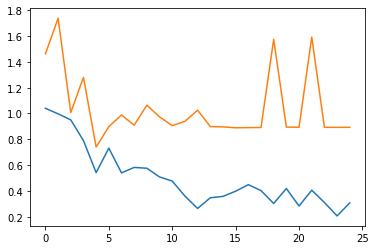

In [38]:
plt.plot(losses['train'])
plt.plot(losses['val'])

In [35]:
torch.save(model_extractor.state_dict(), 'AlexNet_extractor.pth')

In [36]:
model_extractor.load_state_dict(torch.load('AlexNet_extractor.pth'))

<All keys matched successfully>

In [37]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
t

In [39]:
model_mixed = models.alexnet(pretrained=True)

In [40]:
model_mixed

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [48]:
arr = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
print(arr[:-3])

[1, 2, 3, 4, 5, 6, 7]


In [42]:
layers_to_unfreeze = 5
for param in model_mixed.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

num_features = 9216
model_mixed.classifier = nn.Linear(num_features, 2)
if use_gpu:
    model_mixed = model_mixed.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(list(model_mixed.features.parameters())[-layers_to_unfreeze:] + 
                      list(model_mixed.classifier.parameters()), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
%%time
_, losses = train_model(model_mixed, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.4182 Acc: 0.6352
val Loss: 0.1687 Acc: 0.6405

Epoch 1/24
----------
train Loss: 0.1472 Acc: 0.7377
val Loss: 0.1314 Acc: 0.7843

Epoch 2/24
----------
train Loss: 0.1286 Acc: 0.7787
val Loss: 0.1247 Acc: 0.7908

Epoch 3/24
----------
train Loss: 0.1179 Acc: 0.8033
val Loss: 0.1201 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.1247 Acc: 0.8484
val Loss: 0.1156 Acc: 0.8562

Epoch 5/24
----------
train Loss: 0.0867 Acc: 0.8607
val Loss: 0.0963 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.0761 Acc: 0.8648
val Loss: 0.1037 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.0669 Acc: 0.8893
val Loss: 0.0917 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0441 Acc: 0.9262
val Loss: 0.0916 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.0502 Acc: 0.9221
val Loss: 0.0963 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.0516 Acc: 0.8975
val Loss: 0.0913 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.0463 Acc: 0.9180
val Loss: 0.0945 Acc: 0.9150

Ep

In [44]:
torch.save(model_mixed.state_dict(), 'AlexNet_mixed.pth')


In [45]:
model_mixed.load_state_dict(torch.load('AlexNet_mixed.pth'))


<All keys matched successfully>

In [46]:
print("Accuracy: {0:.4f}".format(evaluate(model_mixed)))


tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(3, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(4, device='cuda:0')
tensor(3, device='cuda:0')
t

In [50]:
for param in model_mixed.features.parameters():
    print(param.requires_grad)
    print(param.shape)

False
torch.Size([64, 3, 11, 11])
False
torch.Size([64])
False
torch.Size([192, 64, 5, 5])
False
torch.Size([192])
False
torch.Size([384, 192, 3, 3])
False
torch.Size([384])
True
torch.Size([256, 384, 3, 3])
True
torch.Size([256])
True
torch.Size([256, 256, 3, 3])
True
torch.Size([256])


In [55]:
model_mixed.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)